In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Progbar

tf.random.set_seed(0)

In [2]:
epochs = 150
batch_size = 64
learning_rate = 3e-6

In [4]:
train = pd.read_csv("./dataset/train_data.csv")
test = pd.read_csv("./dataset//test_data.csv")
train = train.drop(train.iloc[581:597,:].index.values) # motor vibe 중 이상치 데이터 삭제
# * train = train[train.type != 3]
# * test = test[test.type != 3].reset_index(drop=True)

ss = RobustScaler()

scaled_train = ss.fit_transform(train)
scaled_test = ss.transform(test)

train_data = scaled_train.reshape(scaled_train.shape[0], 1, scaled_train.shape[1])
test_data = scaled_test.reshape(scaled_test.shape[0], 1, scaled_test.shape[1])

In [5]:
loss_function = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
train_acc_metric = keras.metrics.Accuracy()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-04-19 14:35:06.615485: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-19 14:35:06.616217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
input_layer = keras.layers.Input(shape=(train_data.shape[1], train_data.shape[2]))

encoder = keras.layers.GRU(140, activation="tanh", return_sequences=True, kernel_regularizer=keras.regularizers.l2(1e-9))(input_layer)
encoder = keras.layers.GRU(70, activation="tanh", return_sequences=True)(encoder)
encoder = keras.layers.GRU(35, activation="tanh", return_sequences=False)(encoder)
repeat = keras.layers.RepeatVector(train_data.shape[1])(encoder)
decoder = keras.layers.GRU(35, activation="tanh", return_sequences=True)(repeat)
decoder = keras.layers.GRU(70, activation="tanh", return_sequences=True)(decoder)
decoder = keras.layers.GRU(140, activation="tanh", return_sequences=True)(decoder)
output_layer = keras.layers.Dense(units=train_data.shape[2],input_shape=[2463, 1, 8])(decoder)

GRUAE = keras.Model(inputs=input_layer, outputs=output_layer)
GRUAE.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 gru (GRU)                   (None, 1, 140)            63000     
                                                                 
 gru_1 (GRU)                 (None, 1, 70)             44520     
                                                                 
 gru_2 (GRU)                 (None, 35)                11235     
                                                                 
 repeat_vector (RepeatVector  (None, 1, 35)            0         
 )                                                               
                                                                 
 gru_3 (GRU)                 (None, 1, 35)             7560      
                                                             

In [7]:
class Trainer:
    def __init__(self, model, epochs, batch, loss_function, optimizer, patience=10):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.patience = patience
        self.min_loss = np.Inf
        self.counter = 0

    def train(self, train_data, metric, valid=False):
        history = {'loss':[], 'val_loss':[]}
        if valid == False:
            valid_dataset = []
            train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data)).batch(batch_size)
        else:
            train_dataset, valid_dataset = train_test_split(train_data, test_size=0.2, stratify=train_data[:, 0, 7], random_state=0)
            train_dataset = tf.data.Dataset.from_tensor_slices((train_dataset, train_dataset)).batch(batch_size)
            valid_dataset = tf.data.Dataset.from_tensor_slices((valid_dataset, valid_dataset)).batch(batch_size)
            
        for epoch in range(self.epochs):
            print("\nStart of epoch %d" % (epoch,))
            # Iterate over the batches of the training dataset.

            # progress bar
            progBar = Progbar(len(train_dataset) * self.batch, stateful_metrics=['train_loss', 'val_loss'])
            total_loss = 0
            step = 0

            # start train
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    logits = self.model(x_batch_train, training=True)
                    loss_value = self.loss_function(y_batch_train, logits)
                grads = tape.gradient(loss_value, self.model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
                # Update training metric.
                metric.update_state(y_batch_train, logits)
                total_loss += loss_value/len(x_batch_train)
                values = [('train_loss', loss_value)]
                if valid == False:
                    progBar.update((step + 1) * self.batch, values=values)
                # Log every 5 batches.
                # if step % 5 == 0:
                    # print(
                    #     "Training loss (for one batch) at step %d: %.4f"
                    #     % (step, float(loss_value))
                    # )
                    # print("Seen so far: %d samples" % ((step + 1) * self.batch))
                    # print(metric.result().numpy())
            history['loss'].append(total_loss/step)
            metric.reset_states()
            
            # Calculate validation loss and metric
            if len(valid_dataset):
                valid_loss, valid_acc = self.evaluate(valid_dataset, metric)
                # print("Validation loss: %.4f" % (float(valid_loss),))
                # print("Validation acc: %.4f" % (float(valid_acc),))
                history['val_loss'].append(valid_loss)
                
                # Check if validation loss has improved, if not increase counter
                if valid_loss >= self.min_loss:
                    self.counter += 1
                else:
                    self.min_loss = valid_loss
                    self.counter = 0
                
                # Stop training if counter has reached patience
                if self.counter >= self.patience:
                    print("Validation loss did not improve for %d epochs. Training stopped." % (self.patience,))
                    print(f"Best Validation Loss : {self.min_loss}")
                    break

                # Reset metric states for next epoch
                metric.reset_states()
                values = [('train_loss', loss_value), ('val_loss', valid_loss)]
                progBar.update(len(train_dataset) * self.batch, values=values, finalize=True)

        plot_graph(history)

    def evaluate(self, dataset, metric):
        losses = []
        for x, y in dataset:
            logits = self.model(x, training=False)
            loss_value = self.loss_function(y, logits)
            losses.append(loss_value/len(x))
            metric.update_state(y, logits)
        mean_loss = np.mean(losses)
        mean_metric = metric.result()
        return mean_loss, mean_metric
    
def plot_graph(history):
    # print(history['loss'])
    plt.plot(history["loss"], linewidth=2, label="train")
    plt.plot(history["val_loss"], linewidth=2, label="test")
    plt.legend(loc="upper right")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()


In [8]:
trainer = Trainer(model=GRUAE,
                  epochs=epochs,
                  loss_function=loss_function,
                  optimizer=optimizer,
                  batch=batch_size)
trainer.train(train_data=train_data,
              metric=train_acc_metric,
              valid=True)


Start of epoch 0
1984/1984 [==============================] - 3s 1ms/step - train_loss: 0.4094 - val_loss: 0.0058

Start of epoch 1
1984/1984 [==============================] - 1s 672us/step - train_loss: 0.4093 - val_loss: 0.0058

Start of epoch 2
1984/1984 [==============================] - 1s 716us/step - train_loss: 0.4092 - val_loss: 0.0058

Start of epoch 3
1984/1984 [==============================] - 1s 678us/step - train_loss: 0.4090 - val_loss: 0.0058

Start of epoch 4
1984/1984 [==============================] - 1s 641us/step - train_loss: 0.4089 - val_loss: 0.0058

Start of epoch 5
1984/1984 [==============================] - 1s 641us/step - train_loss: 0.4088 - val_loss: 0.0058

Start of epoch 6
1984/1984 [==============================] - 1s 641us/step - train_loss: 0.4086 - val_loss: 0.0058

Start of epoch 7
1984/1984 [==============================] - 1s 638us/step - train_loss: 0.4085 - val_loss: 0.0058

Start of epoch 8
1984/1984 [==============================] - 1s 

2023-04-18 22:48:00.918951: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


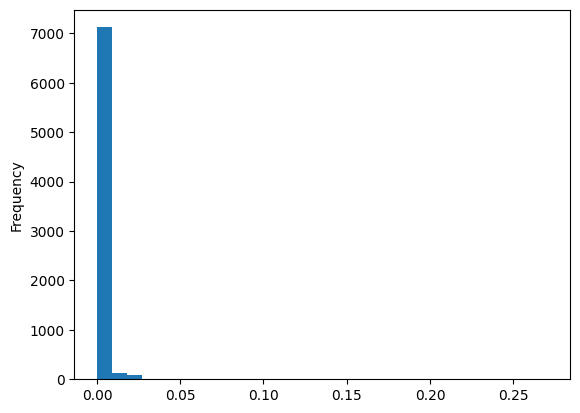

In [8]:
pred = GRUAE.predict(test_data)

pred = pred.reshape(pred.shape[0], pred.shape[2])
test_data = test_data.reshape(test_data.shape[0], test_data.shape[2])

mse = np.mean(np.power(test_data - pred, 2), axis=1)
error_df = pd.DataFrame({"reconsturction_error" : mse, 'type' : test.type})
error_df["reconsturction_error"].plot(kind="hist",bins=30)
plt.show()

In [9]:
sub = pd.read_csv("./answer_sample.csv")
th_pred = pd.read_csv('./best/dongha_best.csv')

error_df['label'] = 0

num_label_1 = 380
# * num_label_1 = 380 - th_pred[th_pred.type == 3].label.sum()
index = error_df.sort_values(by='reconsturction_error', ascending=False).head(num_label_1).index
error_df.iloc[index, 2] = 1

sub["label"] = error_df["label"]
# type 3은 전체 학습한 것, 나머지는 3을 제외하고 학습한 것
# * concat = pd.concat((error_df[error_df.type.isin([0,1,2])], th_pred[th_pred.type == 3], error_df[error_df.type.isin([4,5,6,7])]))
# * sub.label = concat.label.values

ori_test = pd.read_csv('./test_data.csv')
ori_test["label"] = sub["label"].values
sub["label"].value_counts()

0    7009
1     380
Name: label, dtype: int64

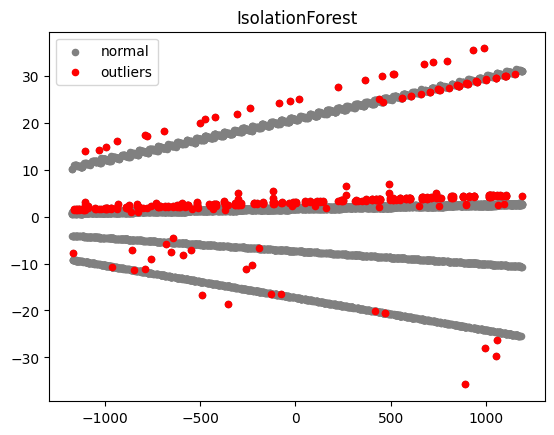

In [10]:
from sklearn.decomposition import PCA

outliers=sub.loc[ori_test['label']==1]
outlier_index=list(outliers.index)

pca = PCA(2)
res = pd.DataFrame(pca.fit_transform(ori_test))

plt.title("IsolationForest")
b1 = plt.scatter(res[0], res[1], c='gray', s=20, label='normal')
b2 = plt.scatter(res.iloc[outlier_index, 0], res.iloc[outlier_index, 1], c='red', s=20, edgecolor="red", label='outliers')
plt.legend()
plt.show()

In [11]:
sub.to_csv("use_total_train.csv", index=False)